In [160]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LassoCV, RidgeCV,LogisticRegression, LogisticRegressionCV, RidgeClassifierCV
import lightgbm as lgbm
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pickle
import requests
import json


In [56]:
df = pd.read_csv('./all_Data.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [57]:
print(df.shape)
df.head()

(793203, 16)


,msno,is_churn,city,registered_via,registration_init_time,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,num_unq,total_songs,songs_repeated,membership_length
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,999,9,2005-04-06,38,30,149,0,2017-01-07,2017-02-06,0,173,188,15,11.84
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,999,9,2005-04-07,39,30,149,1,2017-02-24,2017-03-21,1,1923,2814,891,11.95
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,999,9,2005-10-16,39,30,149,1,2017-01-12,2017-02-03,1,2824,3280,456,11.30
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,9,2005-11-02,38,410,1788,0,2016-01-06,2017-02-20,0,5380,9266,3886,11.30
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,999,9,2005-12-28,38,30,149,0,2016-11-29,2016-12-29,0,19379,19920,541,11.00


In [58]:
# baseline
df.is_churn.value_counts()

0    746051
1     47152
Name: is_churn, dtype: int64

In [59]:
df.transaction_date.max()

'2017-02-28'

In [60]:
data_train= df[df.transaction_date < '2017-02-01 00:00:00']
data_test= df[df.transaction_date >= '2017-02-01 00:00:00']

In [61]:
# drop date time columns
data_train.drop(['registration_init_time', 'transaction_date', 'membership_expire_date'], axis=1,
        inplace=True)
data_test.drop(['registration_init_time', 'transaction_date', 'membership_expire_date'], axis=1,
        inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [62]:
cols = [c for c in data_train.columns if c not in ['is_churn','msno']]
X_train = data_train[cols]
y_train = data_train['is_churn']
X_test = data_test[cols]
y_test = data_test['is_churn']

In [63]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(493851, 11)
(493851,)
(299352, 11)
(299352,)


In [64]:
X_train.head()

,city,registered_via,payment_method_id,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,num_unq,total_songs,songs_repeated,membership_length
0,999,9,38,30,149,0,0,173,188,15,11.84
2,999,9,39,30,149,1,1,2824,3280,456,11.30
3,13,9,38,410,1788,0,0,5380,9266,3886,11.30
4,999,9,38,30,149,0,0,19379,19920,541,11.00
6,13,9,36,30,180,0,0,2011,2737,726,10.84


In [65]:
y_train.value_counts(normalize=True)

0    0.921302
1    0.078698
Name: is_churn, dtype: float64

### Resample

In [66]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

## Modelling

In [67]:
# function for running and evaluating models
def modeller(model):
    print(model)
    clf = model.fit(x_train_res,y_train_res)
    y_pred = clf.predict(X_test)
    print('___'*10 + 'Accuracy Score' +'___'*10)
    print()
    print(accuracy_score(y_test,y_pred))
    print()
    print('___'*10 + 'Confusion Matrix' +'___'*10)
    print()
    print(confusion_matrix(y_test,y_pred))
    print()
    print()
    print('___'*10 + 'Classification Report' +'___'*10)
    print()
    print(classification_report(y_test,y_pred))
    print()
    print('___'*10 + 'Log Loss' +'___'*10)
    print()
    print(log_loss(y_test, y_pred))

In [68]:
#KNN Model
modeller(KNeighborsClassifier(n_neighbors=6))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')
______________________________Accuracy Score______________________________

0.7911021138993559

______________________________Confusion Matrix______________________________

[[234488  56577]
 [  5957   2330]]


______________________________Classification Report______________________________

              precision    recall  f1-score   support

           0       0.98      0.81      0.88    291065
           1       0.04      0.28      0.07      8287

    accuracy                           0.79    299352
   macro avg       0.51      0.54      0.48    299352
weighted avg       0.95      0.79      0.86    299352


______________________________Log Loss______________________________

7.215228499903636


In [69]:
# Ridge
modeller(RidgeClassifierCV(cv=5))

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=5,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False)
______________________________Accuracy Score______________________________

0.9010729843127823

______________________________Confusion Matrix______________________________

[[262710  28355]
 [  1259   7028]]


______________________________Classification Report______________________________

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    291065
           1       0.20      0.85      0.32      8287

    accuracy                           0.90    299352
   macro avg       0.60      0.88      0.63    299352
weighted avg       0.97      0.90      0.93    299352


______________________________Log Loss______________________________

3.4168938131163937


In [70]:
# Decision Tree
modeller(DecisionTreeClassifier(random_state=0))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
______________________________Accuracy Score______________________________

0.918133167642107

______________________________Confusion Matrix______________________________

[[271440  19625]
 [  4882   3405]]


______________________________Classification Report______________________________

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    291065
           1       0.15      0.41      0.22      8287

    accuracy                           0.92    299352
   macro avg       0.57      0.67      0.59    299352
weighted avg       0.96      0.92

In [71]:
# Random Forrest
modeller(RanbdomForestClassifier())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


______________________________Accuracy Score______________________________

0.9540741334616104

______________________________Confusion Matrix______________________________

[[282688   8377]
 [  5371   2916]]


______________________________Classification Report______________________________

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    291065
           1       0.26      0.35      0.30      8287

    accuracy                           0.95    299352
   macro avg       0.62      0.66      0.64    299352
weighted avg       0.96      0.95      0.96    299352


______________________________Log Loss______________________________

1.5862456108691605


In [75]:
# Log Regression
modeller(LogisticRegressionCV(cv=10,max_iter=10000))


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)
______________________________Accuracy Score______________________________

0.9010830059595393

______________________________Confusion Matrix______________________________

[[262776  28289]
 [  1322   6965]]


______________________________Classification Report______________________________

              precision    recall  f1-score   support

           0       0.99      0.90      0.95    291065
           1       0.20      0.84      0.32      8287

    accuracy                           0.90    299352
   macro avg       0.60      0.87      0.63    299352
weighted avg       0.97      0.90      0.93    299352


______________________

In [76]:
# Gradient Boosting
modeller(GradientBoostingClassifier())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
______________________________Accuracy Score______________________________

0.9246839840722627

______________________________Confusion Matrix______________________________

[[271767  19298]
 [  3248   5039]]


______________________________Classification Report______________________________

              precision    rec

In [77]:
modeller(GaussianNB())

GaussianNB(priors=None, var_smoothing=1e-09)
______________________________Accuracy Score______________________________

0.913900692161736

______________________________Confusion Matrix______________________________

[[266903  24162]
 [  1612   6675]]


______________________________Classification Report______________________________

              precision    recall  f1-score   support

           0       0.99      0.92      0.95    291065
           1       0.22      0.81      0.34      8287

    accuracy                           0.91    299352
   macro avg       0.61      0.86      0.65    299352
weighted avg       0.97      0.91      0.94    299352


______________________________Log Loss______________________________

2.9738292801636086


In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross Validation Score")

    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

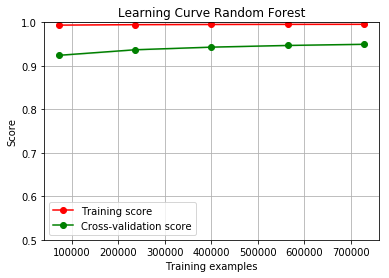

In [87]:
estimator = RandomForestClassifier()
title = 'Learning Curve Random Forest'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(estimator, title, x_train_res,y_train_res, (0.5, 1.0), cv=cv, n_jobs=4)

/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

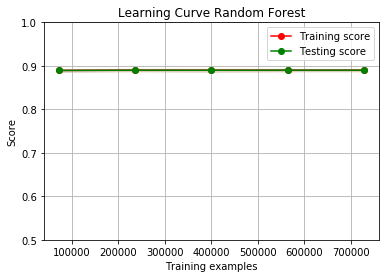

In [115]:
estimator = RandomForestClassifier(max_depth=5)
title = 'Learning Curve Random Forest'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(estimator, title, x_train_res,y_train_res, (0.5, 1.0), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

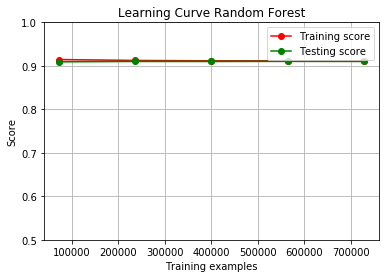

In [116]:
estimator = RandomForestClassifier(max_depth=10)
title = 'Learning Curve Random Forest'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(estimator, title, x_train_res,y_train_res, (0.5, 1.0), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

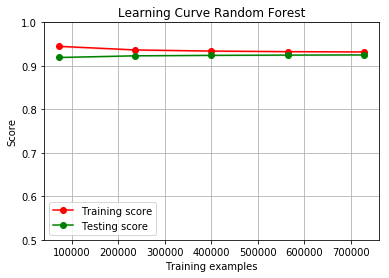

In [117]:
estimator = RandomForestClassifier(max_depth=15)
title = 'Learning Curve Random Forest'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(estimator, title, x_train_res,y_train_res, (0.5, 1.0), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

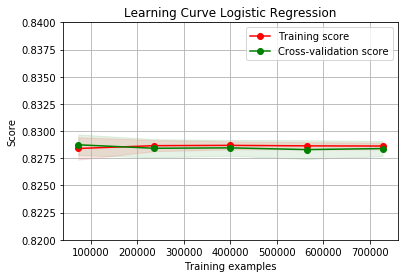

In [96]:
estimator = LogisticRegression()
title = 'Learning Curve Logistic Regression'
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(estimator, title, x_train_res,y_train_res, (0.82, 0.84), cv=cv, n_jobs=4)

/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

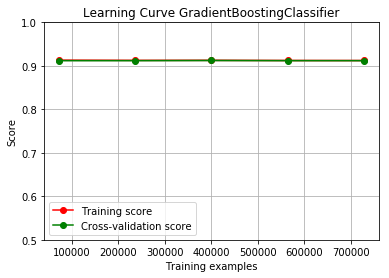

In [109]:
estimator = GradientBoostingClassifier()
title = 'Learning Curve GradientBoostingClassifier'
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(estimator, title, x_train_res,y_train_res, (0.5, 1.0), cv=cv, n_jobs=4)

### Observations:
random forrest classifier(max_depth=15) has the best accuracy/precision scores, also beast learning curve- low variance between training and cross validation


### Model Optimisation

In [125]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'criterion' :['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [10, 25, 50]
}
# Create a based model
rf = RandomForestClassifier(max_depth=15)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [126]:
grid_search.fit(x_train_res,y_train_res)
grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.4min
/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 14.0min finished


{'bootstrap': False,
 'criterion': 'gini',
 'max_features': 'auto',
 'n_estimators': 25}

In [127]:
modeller(RandomForestClassifier(max_depth=15, bootstrap=False, criterion='gini', max_features='auto',
                                n_estimators=25))

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
______________________________Accuracy Score______________________________

0.9401039578823592

______________________________Confusion Matrix______________________________

[[277334  13731]
 [  4199   4088]]


______________________________Classification Report______________________________

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    291065
           1       0.23      0.49      0.31      8287

    accuracy                           0.94    299352

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

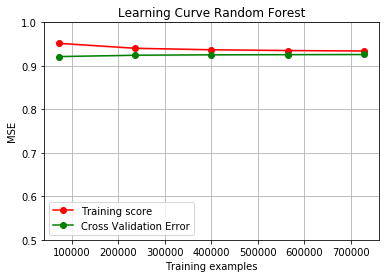

In [128]:
estimator = RandomForestClassifier(max_depth=15, bootstrap=False, criterion='gini',
                                   max_features='auto', n_estimators=25)
title = 'Learning Curve Random Forest'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(estimator, title, x_train_res,y_train_res, (0.5, 1.0), cv=cv, n_jobs=4)

In [129]:
modeller(RandomForestClassifier(max_depth=10, bootstrap=False, criterion='gini', max_features='auto',
                                n_estimators=25))

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
______________________________Accuracy Score______________________________

0.9207955851305486

______________________________Confusion Matrix______________________________

[[270495  20570]
 [  3140   5147]]


______________________________Classification Report______________________________

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    291065
           1       0.20      0.62      0.30      8287

    accuracy                           0.92    299352

/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

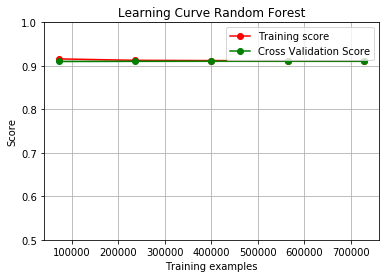

In [162]:
estimator = RandomForestClassifier(max_depth=10, bootstrap=False, criterion='gini',
                                   max_features='auto', n_estimators=25)
title = 'Learning Curve Random Forest'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(estimator, title, x_train_res,y_train_res, (0.5, 1.0), cv=cv, n_jobs=4)

## Decision:
RandomForestClassifier(max_depth=10, bootstrap=True, criterion='gini',max_features='auto', n_estimators=25) model has high accuracy and very low variance (not overfitted). Also this model's confusion matrix is better at predicting the churners than the other model, which has a higher accuracy and higher variance (though it looks as though the more training sample the less the variance will become) where the confusion matrix is more in favour of predicting the non churners

# Final Model

In [166]:
rf = RandomForestClassifier(max_depth=10, bootstrap=False,criterion='gini',
                            max_features='auto',n_estimators=25)
rf = rf.fit(x_train_res,y_train_res)


In [167]:
y_pred = rf.predict(X_test)
print('___'*11 + 'Accuracy Score' +'___'*11)
print()
print(accuracy_score(y_test,y_pred))
print()
print('___'*10 + 'Confusion Matrix' +'___'*10)
print()
print(confusion_matrix(y_test,y_pred))
print()
print('___'*7 + 'Classification Report' +'___'*8)
print()
print(classification_report(y_test,y_pred))
print()
print('___'*14 + 'Log Loss' +'___'*14)
print()
print(log_loss(y_test, y_pred))

_________________________________Accuracy Score_________________________________

0.9169038456399156

______________________________Confusion Matrix______________________________

[[269447  21618]
 [  3257   5030]]

_____________________Classification Report________________________

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    291065
           1       0.19      0.61      0.29      8287

    accuracy                           0.92    299352
   macro avg       0.59      0.77      0.62    299352
weighted avg       0.97      0.92      0.94    299352


__________________________________________Log Loss__________________________________________

2.8700972384371894


In [168]:
## Pickle final model
pickle.dump(rf, open('churner_model.pkl', 'wb'))

In [172]:
## Test model 
model = pickle.load(open('churner_model.pkl','rb'))
print(model.predict([[1,2,3,4,5,6,7,8,9,10,11]]))

[1]


In [175]:
X_train.columns

Index(['city', 'registered_via', 'payment_method_id', 'payment_plan_days',
       'actual_amount_paid', 'is_auto_renew', 'is_cancel', 'num_unq',
       'total_songs', 'songs_repeated', 'membership_length'],
      dtype='object')